# **Fraud Detection Using AutoEncoders**





**This is the list of our group members:**

1. Vadapalli Sai Sravan (CS24MTECH02007)
2. Supreet Shukla (CS24MTECH02004)
3. Tarun Jangir (CS24MTECH02005)
4. Taufique Ramzan Shaikh (CS24MTECH02006)
5. Afzaal Ahmad (CS24MTECH02002)

# **Training the First Auto Encoder**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Load and preprocess data
data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

# Separate features and labels
X = data.drop('Class', axis=1)
y = data['Class']

# Log-scale the time difference and amount features
time_diff_idx = X.columns.get_loc('Time')
amount_idx = X.columns.get_loc('Amount')

X.iloc[:, time_diff_idx] = np.log1p(X.iloc[:, time_diff_idx])  # Log-scale time difference
X.iloc[:, amount_idx] = np.log1p(X.iloc[:, amount_idx])  # Log-scale amount

# Normalize features to the range (0, 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Separate fraud and non-fraud transactions
non_fraud_idx = np.where(y == 0)[0]
fraud_idx = np.where(y == 1)[0]

# Split non-fraud data into train and validation sets
X_non_fraud = X[non_fraud_idx]
y_non_fraud = y[non_fraud_idx]
X_train, X_val, y_train, y_val = train_test_split(X_non_fraud, y_non_fraud, test_size=0.001, random_state=42)

# Create test set with remaining non-fraud data and all fraud data
X_test_non_fraud = np.delete(X[non_fraud_idx], np.concatenate((np.arange(len(X_train)), np.arange(len(X_val)))), axis=0)
X_test = np.concatenate((X_test_non_fraud, X[fraud_idx]), axis=0)
y_test_non_fraud = np.delete(y[non_fraud_idx], np.concatenate((np.arange(len(y_train)), np.arange(len(y_val)))), axis=0)
y_test = np.concatenate((y_test_non_fraud, y[fraud_idx]), axis=0)

# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='tanh')(input_layer)
decoded = Dense(input_dim, activation='tanh')(encoded)

# Create the autoencoder model
autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_val, X_val))

# Compute reconstruction errors for training data
train_reconstructions = autoencoder.predict(X_train)
reconstruction_errors_train = np.mean(np.square(X_train - train_reconstructions), axis=1)
non_fraud_train_errors = reconstruction_errors_train

# Calculate threshold using the reconstruction errors of non-fraudulent transactions in the training set
threshold = np.mean(non_fraud_train_errors) + 2.5 * np.std(non_fraud_train_errors)

# Compute reconstruction errors for testing data
test_reconstructions = autoencoder.predict(X_test)
reconstruction_errors_test = np.mean(np.square(X_test - test_reconstructions), axis=1)

# Classify transactions as fraud or non-fraud based on the threshold
y_pred_test = [1 if e > threshold else 0 for e in reconstruction_errors_test]


Epoch 1/100
8876/8876 [==============================] - 29s 3ms/step - loss: 0.0025 - val_loss: 4.1112e-04
Epoch 2/100
8876/8876 [==============================] - 23s 3ms/step - loss: 2.9977e-04 - val_loss: 2.1401e-04
Epoch 3/100
8876/8876 [==============================] - 24s 3ms/step - loss: 2.2685e-04 - val_loss: 1.9409e-04
Epoch 4/100
8876/8876 [==============================] - 22s 3ms/step - loss: 2.1356e-04 - val_loss: 1.8384e-04
Epoch 5/100
8876/8876 [==============================] - 24s 3ms/step - loss: 2.0335e-04 - val_loss: 1.7507e-04
Epoch 6/100
8876/8876 [==============================] - 24s 3ms/step - loss: 1.9536e-04 - val_loss: 1.6612e-04
Epoch 7/100
8876/8876 [==============================] - 25s 3ms/step - loss: 1.8967e-04 - val_loss: 1.6448e-04
Epoch 8/100
8876/8876 [==============================] - 27s 3ms/step - loss: 1.8584e-04 - val_loss: 1.6106e-04
Epoch 9/100
8876/8876 [==============================] - 25s 3ms/step - loss: 1.8266e-04 - val_loss: 1.5855e

# **Evaluate model performance on test set using first Auto Encoder**

In [ ]:
from sklearn.metrics import precision_score,  recall_score

precision = precision_score(y_test, y_pred_test)
print(f"precision is: {precision}")
recall = recall_score(y_test, y_pred_test)
print(f"recall is: {recall}")

f1 = f1_score(y_test, y_pred_test)
print(f'F1 score on test set: {f1}')

precision is: 0.9898477157360406
recall is: 0.7926829268292683
F1 score on test set: 0.8803611738148984


# **Plotting Reconstruction Error Distribution**

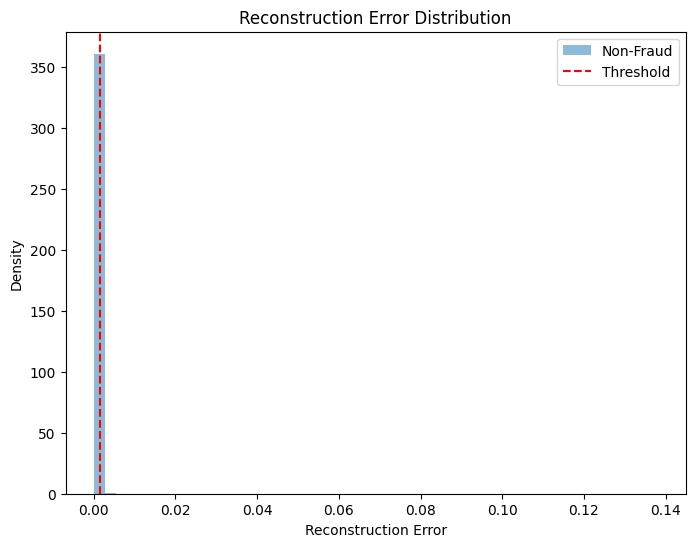

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(non_fraud_train_errors, bins=50, alpha=0.5, label='Non-Fraud', density=True)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

# **Training the Second Auto Encoder**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Load and preprocess data
data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

# Separate features and labels
X = data.drop('Class', axis=1)
y = data['Class']

# Log-scale the time difference and amount features
time_diff_idx = X.columns.get_loc('Time')
amount_idx = X.columns.get_loc('Amount')

X.iloc[:, time_diff_idx] = np.log1p(X.iloc[:, time_diff_idx])  # Log-scale time difference
X.iloc[:, amount_idx] = np.log1p(X.iloc[:, amount_idx])  # Log-scale amount

# Normalize features to the range (0, 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Separate fraud and non-fraud transactions
non_fraud_idx = np.where(y == 0)[0]
fraud_idx = np.where(y == 1)[0]

# Split non-fraud data into train and validation sets
X_non_fraud = X[non_fraud_idx]
y_non_fraud = y[non_fraud_idx]
X_train, X_val, y_train, y_val = train_test_split(X_non_fraud, y_non_fraud, test_size=0.001, random_state=42)

# Create test set with remaining non-fraud data and all fraud data
X_test_non_fraud = np.delete(X[non_fraud_idx], np.concatenate((np.arange(len(X_train)), np.arange(len(X_val)))), axis=0)
X_test = np.concatenate((X_test_non_fraud, X[fraud_idx]), axis=0)
y_test_non_fraud = np.delete(y[non_fraud_idx], np.concatenate((np.arange(len(y_train)), np.arange(len(y_val)))), axis=0)
y_test = np.concatenate((y_test_non_fraud, y[fraud_idx]), axis=0)

# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 10  # Choose the dimension of the encoded representation
hidden_dim = 14  # Dimension of the hidden layers

input_layer = Input(shape=(input_dim,))
hidden_encoder = Dense(hidden_dim, activation='tanh')(input_layer)
encoded = Dense(encoding_dim, activation='tanh')(hidden_encoder)
hidden_decoder = Dense(hidden_dim, activation='tanh')(encoded)
decoded = Dense(input_dim, activation='tanh')(hidden_decoder)

# Create the autoencoder model
autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_val, X_val))

# Compute reconstruction errors for training data
train_reconstructions = autoencoder.predict(X_train)
reconstruction_errors_train = np.mean(np.square(X_train - train_reconstructions), axis=1)

# Compute the mean reconstruction error on non-fraud training data
non_fraud_train_errors = reconstruction_errors_train

# Calculate threshold using the reconstruction errors of non-fraudulent transactions in the training set
threshold = np.mean(non_fraud_train_errors) + 2.5 * np.std(non_fraud_train_errors)

# Compute reconstruction errors for testing data
test_reconstructions = autoencoder.predict(X_test)
reconstruction_errors_test = np.mean(np.square(X_test - test_reconstructions), axis=1)

# Classify transactions as fraud or non-fraud based on the threshold
y_pred_test = [1 if e > threshold else 0 for e in reconstruction_errors_test]

# Evaluate model performance on test set
f1 = f1_score(y_test, y_pred_test)
print(f'F1 score on test set: {f1}')


Epoch 1/100
8876/8876 [==============================] - 33s 4ms/step - loss: 0.0024 - val_loss: 5.2770e-04
Epoch 2/100
8876/8876 [==============================] - 29s 3ms/step - loss: 4.2442e-04 - val_loss: 3.3685e-04
Epoch 3/100
8876/8876 [==============================] - 32s 4ms/step - loss: 3.4157e-04 - val_loss: 3.0721e-04
Epoch 4/100
8876/8876 [==============================] - 28s 3ms/step - loss: 3.3235e-04 - val_loss: 3.0600e-04
Epoch 5/100
8876/8876 [==============================] - 29s 3ms/step - loss: 3.2660e-04 - val_loss: 3.0566e-04
Epoch 6/100
8876/8876 [==============================] - 29s 3ms/step - loss: 3.2296e-04 - val_loss: 3.0640e-04
Epoch 7/100
8876/8876 [==============================] - 29s 3ms/step - loss: 3.1769e-04 - val_loss: 2.9928e-04
Epoch 8/100
8876/8876 [==============================] - 29s 3ms/step - loss: 3.1002e-04 - val_loss: 2.9737e-04
Epoch 9/100
8876/8876 [==============================] - 29s 3ms/step - loss: 3.0325e-04 - val_loss: 2.7274e

# **Evaluate model performance on test set using second Auto Encoder**

In [ ]:
from sklearn.metrics import precision_score,  recall_score

precision = precision_score(y_test, y_pred_test)
print(f"precision is: {precision}")
recall = recall_score(y_test, y_pred_test)
print(f"recall is: {recall}")

f1 = f1_score(y_test, y_pred_test)
print(f'F1 score on test set: {f1}')

precision is: 0.9927007299270073
recall is: 0.8292682926829268
F1 score on test set: 0.9036544850498338


# **SUMMARY**

**Introduction**: This code implements an autoencoder model for fraud detection in credit card transactions. The autoencoder is an unsupervised learning technique that learns to reconstruct the input data by compressing it into a lower-dimensional representation and then decompressing it back to the original dimensions.

**Data Preprocessing**: The code loads a credit card transaction dataset from a CSV file and preprocesses it. The target variable 'Class' (fraud or non-fraud) is separated from the features. The 'Time' and 'Amount' features are log-scaled, and all features are normalized to the range (0, 1) using MinMaxScaler. The dataset is then split into training, validation, and test sets, ensuring that only non-fraudulent transactions are included in the train set and ensuring that the test set is a combination of fraud and non-fraud transactions.

**Autoencoder Architecture**: The autoencoder architecture consists of an input layer, a hidden encoder layer, a bottleneck layer (encoded representation), a hidden decoder layer, and an output layer.

**Model Training**: The autoencoder is trained on the non-fraudulent transactions in the training set using the mean squared error loss function and the Adam optimizer. The model is trained for 100 epochs, and the validation set is used to monitor the training process. We trained two auto encoders:
**First autoencoder:** 1 encoder layer, 1 bottleneck layer, 1 decoder layer
**Second autoencoder:** 2 encoder layers, 1 bottleneck layer, 2 decoder layers


**Fraud Detection**: After training, the autoencoder computes the reconstruction errors for the training and test sets. The reconstruction error is the mean squared difference between the original input and its reconstructed counterpart. A threshold is calculated based on the reconstruction errors of non-fraudulent transactions in the training set. Transactions with reconstruction errors above the threshold are classified as fraudulent.

**Model Evaluation**: The code evaluates the autoencoder's performance on the test set using the F1-score, precision, and recall metrics. It also plots a histogram of the reconstruction error distribution for non-fraudulent transactions in the training set, highlighting the chosen threshold.

**Performance metrics of First Auto Encoder:**

precision is: 0.9898477157360406

recall is: 0.7926829268292683

F1 score on test set: 0.8803611738148984

**Performance metrics of Second Auto Encoder:**

precision is: 0.9927007299270073

recall is: 0.8292682926829268

F1 score on test set: 0.9036544850498338

